## feeder concept: cutter + barges

This notebook shows how to implement a basic feeder concept for a cutter suction dredge working with multiple barges.

In [1]:
import datetime, time
import simpy

import shapely.geometry
import pandas as pd

import openclsim.core as core
import openclsim.model as model
from openclsim.plot import get_step_chart, get_gantt_chart
import numpy as np

In [2]:
cutter_name    = 'Cutter T'
barge_names    = ['Carrier A','Carrier B','Carrier C',
                  'Barge I','Barge II','Barge III',
                  'Extra 1', 'Extra 2', 'Extra 3']
vessel_cost     = {'Carrier A':6000,'Carrier B':6000,'Carrier C':6000,
                  'Barge I':5000,'Barge II':5000,'Barge III':5000,
                  'Extra 1':4000, 'Extra 2':4000, 'Extra 3':4000,
                  'Cutter T':25000} # EUR/day
# vessel_amount and vessel_durations are random within a range,
# to mimic respectively material density variations
# and metocean workability conditions and traffic density.

amount_range = [4,6]
duration_range = [2000,3000]

from_site_name = 'Trench'
to_site_name   = 'Reclamation'

In [3]:
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
    ),
    {},
)

In [4]:
def run(NR_BARGES, total_amount):
    simulation_start = 0
    my_env = simpy.Environment(initial_time=simulation_start)
    registry = {}

    location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
    location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)

    data_from_site = {"env": my_env,
                      "name": from_site_name,
                      "geometry": location_from_site,
                      "capacity": total_amount,
                      "level": total_amount,
                      "nr_resources":1
                     }
    from_site = Site(**data_from_site)

    location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
    data_to_site = {"env": my_env,
                    "name": to_site_name,
                    "geometry": location_to_site,
                    "capacity": total_amount,
                    "level": 0,
                    "nr_resources":4
                   }
    to_site = Site(**data_to_site)

    vessels = {}

    for i in range(NR_BARGES):
        vessel_name = barge_names[i]
        vessels[vessel_name] = TransportProcessingResource(
            env=my_env,
            name=vessel_name,
            geometry=location_from_site, 
            capacity=10,
            compute_v=lambda x: 10
        )
    cutter = TransportProcessingResource(
        env=my_env,
        name=cutter_name,
        geometry=location_from_site, 
        capacity=10,
        compute_v=lambda x: 10
    )
    vessels[cutter_name] = cutter
    

    activities = {}
    for i in range(NR_BARGES):
        vessel_name = barge_names[i]
        amount = np.random.randint(amount_range[0], amount_range[1]) # handle loading
        duration=np.random.randint(duration_range[0], duration_range[1]) # sailing and unloading

        requested_resources={}
        activities[f"activity{i}"] = model.WhileActivity(
            env=my_env,
            name=f"while_sequential_activity_subcycle{i}",
            registry=registry,
            sub_processes=[model.SequentialActivity(
                env=my_env,
                name=f"sequential_activity_subcycle{i}",
                registry=registry,
                sub_processes=[
                    model.BasicActivity(
                        env=my_env,
                        name=f"basic activity:"+vessels[vessel_name].name,
                        registry=registry,
                        duration=duration,
                        additional_logs=[vessels[vessel_name]],
                    ),
                    model.MoveActivity(
                        env=my_env,
                        name=f"sailing empty:"+vessels[vessel_name].name,
                        registry=registry,
                        mover=vessels[vessel_name],
                        destination=from_site,
                        duration=duration,
                    ),
                    model.ShiftAmountActivity(
                        env=my_env,
                        name=f"loading:"+vessels[vessel_name].name,
                        registry=registry,
                        processor=cutter,
                        origin=from_site,
                        destination=vessels[vessel_name],
                        amount=amount,
                        duration=500*amount,
                        requested_resources=requested_resources,
                    ),
                    model.MoveActivity(
                        env=my_env,
                        name=f"sailing full:"+vessels[vessel_name].name,
                        registry=registry,
                        mover=vessels[vessel_name],
                        destination=to_site,
                        duration=duration,
                    ),
                    model.ShiftAmountActivity(
                        env=my_env,
                        name=f"unloading:"+vessels[vessel_name].name,
                        registry=registry,
                        processor=vessels[vessel_name],
                        origin=vessels[vessel_name],
                        destination=to_site,
                        amount=amount,
                        duration=duration,
                        requested_resources=requested_resources,
                    ),
                ],
            )],
            condition_event=[
                {
                    "type": "container", 
                    "concept": to_site, 
                    "state": "full",
                    "id_":"default_reservations"
                }
            ],
        )

    model.register_processes(list(activities.values()))
    my_env.run()
    
    return {
        "vessels": vessels,
        "activities":activities,
        from_site_name:from_site,
        to_site_name:to_site,
    }


In [5]:
%%time
nbarges = len(barge_names)
assert len(set(barge_names))==len(barge_names), 'barge_names need to be unique'
total_amount = 100
res = run(nbarges,total_amount)
vessels = res['vessels']
activities = res['activities']
cutter = vessels[cutter_name]
to_site = res[to_site_name]
from_site = res[from_site_name]

CPU times: user 54.2 ms, sys: 4 ms, total: 58.2 ms
Wall time: 53 ms


In [6]:
fig = get_gantt_chart(vessels, id_map=activities)


In [7]:
fig = get_gantt_chart([from_site, to_site, cutter], id_map=activities)

Plot only activities whose namespace (first letters) matches load*

In [8]:
def expand(a, namespace):
    n = len(namespace)
    sa = []
    if a.name[0:n]==namespace:
        sa.append(a)
    if hasattr(a, "sub_processes"):
        for s in a.sub_processes:
            if s.name[0:n]==namespace:
                sa.append(s)
            sa+=expand(s,namespace)
    return sa
all_activities = []
for a in [*activities]:
    all_activities+=expand(activities[a],'load')
all_activities
fig = get_gantt_chart(all_activities)

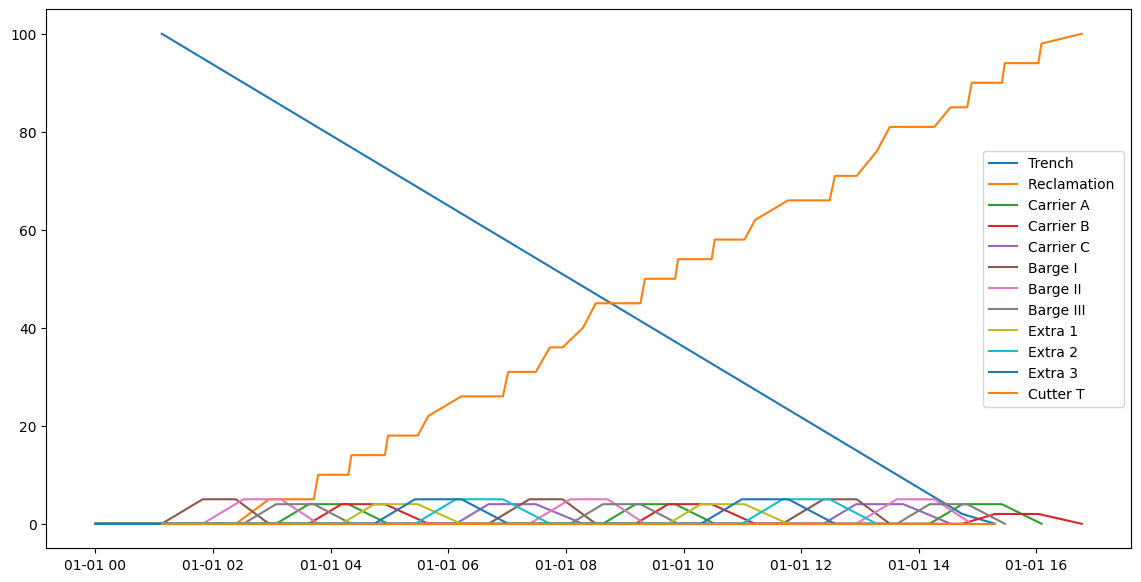

In [9]:
fig = get_step_chart([from_site, to_site, *vessels.values()])

In [10]:
def occupancy_analysis(vessels, cutter, activities, vessel_cost):
    data = []
    duration_theory_cutter = 0
    nr_trips_cutter = 0

    # barges
    for i, vessel_name in enumerate(vessels):
        if vessel_name!=cutter_name:
            vessel = vessels[vessel_name]
            activity = activities[f'activity{i}']

            log = pd.DataFrame(vessel.log)
            sub_act = activity.sub_processes[0].sub_processes[-1] # last phase of SequentialActivity ..
            nr_trips = len(log[(log.ActivityID == sub_act.id) & (log.ActivityState == "STOP")]) # .. ended
            nr_trips_cutter += nr_trips

            duration_theory = 0
            for sub_act in activity.sub_processes[0].sub_processes:
                duration_theory+=sub_act.duration
                if hasattr(sub_act,'processor'):
                    if sub_act.processor.name==cutter_name:
                        duration_theory_cutter += sub_act.duration*nr_trips

            duration_actual = (log.Timestamp.max() - log.Timestamp.min()).total_seconds()
            data.append({
                'name':vessel.name, 
                '# trips':nr_trips, 
                'duration actual': duration_actual,
                'cost':duration_actual*vessel_cost[vessel_name]/3600/24,
                'production actual':(nr_trips * sub_act.amount) / (duration_actual),
                'production theory': (sub_act.amount / (duration_theory)),
            })

    # cutter
    log = pd.DataFrame(cutter.log)
    duration_actual_cutter = (log.Timestamp.max() - log.Timestamp.min()).total_seconds()
    data.append({
        'name':cutter_name, 
        '# trips':nr_trips_cutter, 
        'duration actual': duration_actual_cutter,
        'cost':duration_actual_cutter*vessel_cost[cutter_name]/3600/24,
        'production actual':(total_amount) / (duration_actual_cutter),
        'production theory':(total_amount) / (duration_theory_cutter),
    })

    df = pd.DataFrame(data).sort_values(by=['production actual'],ascending=False)
    df['occupancy [%]'] = [round(x,1) for x in 100*df['production actual']/df['production theory']]
    df.set_index('name', inplace=True)
    
    print(f'Occupancy "{cutter_name}":', df.loc[cutter_name]['occupancy [%]'],'%')
    print(f'Total cost',df['cost'].sum())
    
    return df

In [11]:
results = []
occupancy = []
cost = []
for i in range(len(barge_names)):
    results.append(run(i+1,total_amount)) # at least 1 barge
    vessels = results[i]['vessels']
    activities = results[i]['activities']
    cutter = vessels[cutter_name]
    to_site = results[i][to_site_name]
    from_site = results[i][from_site_name]
    df = occupancy_analysis(vessels, cutter, activities,vessel_cost)
    occupancy.append(df.loc[cutter_name]['occupancy [%]'])
    cost.append(df['cost'].sum())
    display(df)

Occupancy "Cutter T": 21.1 %
Total cost 85896.52777777778


,# trips,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,
Cutter T,20,237492.0,68718.750000,0.000421,0.002000,21.1
Carrier A,20,247360.0,17177.777778,0.000404,0.000404,100.0


Occupancy "Cutter T": 37.0 %
Total cost 58459.81481481482


,# trips,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,
Cutter T,20,134996.0,39061.342593,0.000741,0.002000,37.0
Carrier B,10,133264.0,9254.444444,0.000375,0.000393,95.4
Carrier A,10,146074.0,10144.027778,0.000342,0.000346,98.9


Occupancy "Cutter T": 54.3 %
Total cost 46845.648148148146


,# trips,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,
Cutter T,23,92084.0,26644.675926,0.001086,0.002000,54.3
Carrier C,8,101966.0,7080.972222,0.000392,0.000400,98.2
Carrier A,8,95196.0,6610.833333,0.000336,0.000340,98.8
Carrier B,7,93732.0,6509.166667,0.000299,0.000312,95.8


Occupancy "Cutter T": 74.5 %
Total cost 39318.26388888889


,# trips,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,
Cutter T,22,69816.0,20201.388889,0.001432,0.001923,74.5
Carrier A,6,73106.0,5076.805556,0.000410,0.000440,93.3
Carrier B,5,66762.0,4636.250000,0.000374,0.000438,85.5
Carrier C,6,68660.0,4768.055556,0.000350,0.000373,93.6
Barge I,5,80106.0,4635.763889,0.000312,0.000348,89.7


Occupancy "Cutter T": 81.0 %
Total cost 39219.74537037037


,# trips,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,
Cutter T,25,61736.0,17863.425926,0.001620,0.002000,81.0
Barge I,6,64580.0,3737.268519,0.000372,0.000398,93.5
Carrier C,5,61390.0,4263.194444,0.000326,0.000342,95.1
Barge II,5,67906.0,3929.745370,0.000295,0.000315,93.6
Carrier B,5,71344.0,4954.444444,0.000280,0.000304,92.2
Carrier A,4,64392.0,4471.666667,0.000248,0.000292,85.0


Occupancy "Cutter T": 99.9 %
Total cost 35649.351851851854


,# trips,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,
Cutter T,22,51068.0,14776.620370,0.001958,0.001961,99.9
Carrier B,4,47872.0,3324.444444,0.000418,0.000460,90.8
Carrier A,4,53288.0,3700.555556,0.000375,0.000432,86.8
Barge II,3,51894.0,3003.125000,0.000289,0.000359,80.4
Carrier C,4,57904.0,4021.111111,0.000276,0.000354,78.1
Barge III,3,57044.0,3301.157407,0.000263,0.000355,74.0
Barge I,4,60866.0,3522.337963,0.000263,0.000302,86.9


Occupancy "Cutter T": 100.0 %
Total cost 37898.35648148148


,# trips,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,
Cutter T,23,51000.0,14756.944444,0.001961,0.001961,100.0
Extra 1,4,60270.0,2790.277778,0.000332,0.000418,79.3
Barge I,3,50058.0,2896.875000,0.000300,0.000370,81.1
Barge II,4,53588.0,3101.157407,0.000299,0.000361,82.8
Barge III,3,52664.0,3047.685185,0.000285,0.000364,78.3
Carrier C,3,47228.0,3279.722222,0.000254,0.000323,78.6
Carrier A,3,56782.0,3943.194444,0.000211,0.000297,71.2
Carrier B,3,58788.0,4082.500000,0.000204,0.000297,68.8


Occupancy "Cutter T": 100.0 %
Total cost 39165.231481481474


,# trips,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,
Cutter T,23,50000.0,14467.592593,0.002000,0.002000,100.0
Barge II,3,48146.0,2786.226852,0.000312,0.000425,73.4
Barge I,3,50722.0,2935.300926,0.000296,0.000419,70.5
Extra 1,3,42520.0,1968.518519,0.000282,0.000399,70.7
Barge III,3,53044.0,3069.675926,0.000226,0.000331,68.3
Extra 2,3,55188.0,2555.000000,0.000217,0.000324,67.2
Carrier A,2,46712.0,3243.888889,0.000214,0.000360,59.5
Carrier C,3,57536.0,3995.555556,0.000209,0.000306,68.1
Carrier B,3,59666.0,4143.472222,0.000201,0.000300,66.9


Occupancy "Cutter T": 100.0 %
Total cost 42222.80092592593


,# trips,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,
Cutter T,23,52000.0,15046.296296,0.001923,0.001923,100.0
Extra 1,3,49368.0,2285.555556,0.000304,0.000440,69.1
Extra 3,3,54010.0,2500.462963,0.000278,0.000429,64.7
Extra 2,3,58846.0,2724.351852,0.000255,0.000406,62.8
Carrier C,3,61364.0,4261.388889,0.000244,0.000405,60.4
Barge III,3,56160.0,3250.000000,0.000214,0.000349,61.2
Barge II,2,43578.0,2521.875000,0.000184,0.000326,56.4
Barge I,2,45844.0,2653.009259,0.000175,0.000312,55.9
Carrier A,2,47850.0,3322.916667,0.000167,0.000312,53.6


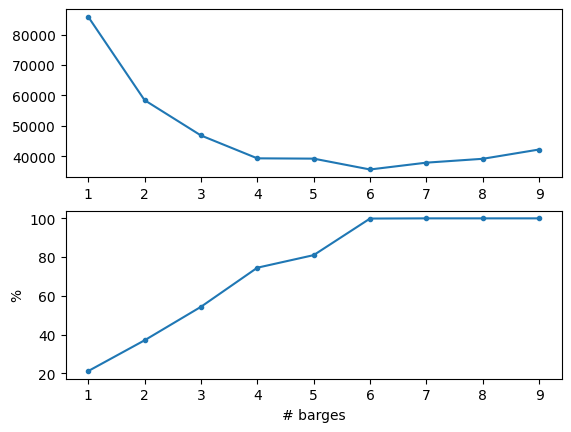

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
axs[0].plot(range(1,len(cost)+1),cost,'.-'), axs[1].set_ylabel('EUR');
axs[1].plot(range(1,len(cost)+1),occupancy,'.-'), axs[1].set_ylabel('%');
axs[1].set_xlabel('# barges');

## Visualize critical path cutter

For explanation of Critical Path see notebook 30

In [13]:
from openclsim.plot.critical_path import CpLog

In [16]:
i = 0 # 1 barge
vessels = results[i]['vessels']
activities = results[i]['activities']
cutter = vessels[cutter_name]
to_site = results[i][to_site_name]
from_site = results[i][from_site_name]
  
my_objects = list(vessels.values()) + [from_site, to_site]
my_activities = list(activities.values())
my_log = CpLog(list_objects=my_objects, list_activities=my_activities)
dependencies_log = my_log.get_dependencies_log_based()
cp_log_based = my_log.mark_critical_activities(dependencies_log)
df = occupancy_analysis(vessels, cutter, activities,vessel_cost)
t = f'{cutter_name} occupancy: ' + str(df.loc[cutter_name]['occupancy [%]'])
fig = get_gantt_chart(concepts=my_objects, critical_path=cp_log_based, id_map=activities, title=t)

Occupancy "Cutter T": 21.1 %
Total cost 85896.52777777778


In [17]:
i = 1 # 2 barge
vessels = results[i]['vessels']
activities = results[i]['activities']
cutter = vessels[cutter_name]
to_site = results[i][to_site_name]
from_site = results[i][from_site_name]
  
my_objects = list(vessels.values()) + [from_site, to_site]
my_activities = list(activities.values())
my_log = CpLog(list_objects=my_objects, list_activities=my_activities)
dependencies = my_log.get_dependencies_model_based()
# dependencies = my_log.get_dependencies_log_based()
cp = my_log.mark_critical_activities(dependencies)
df = occupancy_analysis(vessels, cutter, activities,vessel_cost)
t = f'{cutter_name} occupancy: ' + str(df.loc[cutter_name]['occupancy [%]'])
fig = get_gantt_chart(concepts=my_objects, critical_path=cp, id_map=activities, title=t)

Occupancy "Cutter T": 37.0 %
Total cost 58459.81481481482


In [22]:
i = 6 # many barges: 100% cutter config
vessels = results[i]['vessels']
activities = results[i]['activities']
cutter = vessels[cutter_name]
to_site = results[i][to_site_name]
from_site = results[i][from_site_name]
  
my_objects = list(vessels.values()) + [from_site, to_site]
my_activities = list(activities.values())
my_log = CpLog(list_objects=my_objects, list_activities=my_activities)
# dependencies = my_log.get_dependencies_model_based()
dependencies = my_log.get_dependencies_log_based()
cp = my_log.mark_critical_activities(dependencies)
df = occupancy_analysis(vessels, cutter, activities,vessel_cost)
t = f'{cutter_name} occupancy: ' + str(df.loc[cutter_name]['occupancy [%]'])
fig = get_gantt_chart(concepts=my_objects, critical_path=cp, id_map=activities, title=t)

Occupancy "Cutter T": 100.0 %
Total cost 37898.35648148148


In [23]:
i = 6 # many barges: 100% cutter config
vessels = results[i]['vessels']
activities = results[i]['activities']
cutter = vessels[cutter_name]
to_site = results[i][to_site_name]
from_site = results[i][from_site_name]
  
my_objects = list(vessels.values()) + [from_site, to_site]
my_activities = list(activities.values())
my_log = CpLog(list_objects=my_objects, list_activities=my_activities)
dependencies = my_log.get_dependencies_model_based()
# dependencies = my_log.get_dependencies_log_based()
cp = my_log.mark_critical_activities(dependencies)
df = occupancy_analysis(vessels, cutter, activities,vessel_cost)
t = f'{cutter_name} occupancy: ' + str(df.loc[cutter_name]['occupancy [%]'])
fig = get_gantt_chart(concepts=my_objects, critical_path=cp, id_map=activities, title=t)

Occupancy "Cutter T": 100.0 %
Total cost 37898.35648148148
